In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import hilbert
from antropy import sample_entropy
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import glob
from collections import Counter
from sklearn.utils import resample

In [ ]:
folder = "C:/Users/lazar/Desktop/pfe signali/odri"

all_files = glob.glob(os.path.join(folder, "*.csv"))

df_list = [pd.read_csv(f) for f in all_files]
df = pd.concat(df_list, ignore_index=True)
df = df.drop(columns=["TIMESTAMP"])
df = df[df['Sleep_Stage'] != 'P']

In [ ]:
signal = df['F4-M1'].values

fs = 100 
epoch_length = 10  
samples_per_epoch = fs * epoch_length 

num_epochs = len(signal) // samples_per_epoch
epohe = np.array_split(signal[:num_epochs * samples_per_epoch], num_epochs)
normalized_epochs = []
for epoch in epohe:
    mean = np.mean(epoch)
    std = np.std(epoch)
    if std != 0:
        norm_epoch = (epoch - mean) / std
    else:
        norm_epoch = epoch - mean
    normalized_epochs.append(norm_epoch)

In [ ]:
bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 45)
}

def bandpower(sig, fs, band):  #filtrira signale po frekvencijama
    low, high = band
    b, a = butter(4, [low / (fs / 2), high / (fs / 2)], btype='band')
    filtered = filtfilt(b, a, sig)
    power = np.sum(filtered ** 2) / len(filtered)
    return power
def compute_esis(epoch, fs):

    energy = np.square(epoch)
    slope = np.abs(np.diff(epoch, prepend=epoch[0]))
    v = fs * slope
    esis = np.sum(energy * v)

    return esis

def compute_mmd(epoch, window_size = 50, step_size = 25):
    mmd = 0
    for start in range(0, len(epoch) - window_size, step_size):
        window = epoch[start:start + window_size]

        max_idx = np.argmax(window)
        min_idx = np.argmin(window)

        delta_x = max_idx - min_idx
        delta_y = window[max_idx] - window[min_idx]
        distance = np.sqrt(delta_x**2 + delta_y**2)
        mmd += distance
    return mmd
def compute_features(epoch, fs = 100):
    rms = np.sqrt(np.mean(np.square(epoch))) #ROOT MEAN SQUARE
    mse = np.mean((epoch - np.mean(epoch)) ** 2) #MEAN SQUARED ERROR
    mmd = compute_mmd(epoch) #MINIMAL MAXIMAL DISTANCE
    zcr = ((epoch[:-1] * epoch[1:]) < 0).sum() #ZERO CROSSING RATE
    se = sample_entropy(epoch) #SAMPLE ENTROPY
    esis = compute_esis(epoch, fs)

    talasi = {ime: bandpower(epoch, fs, opseg) for ime, opseg in bands.items()}

    red = {
        "RMS": rms,
        "MSE": mse,
        "MMD": mmd,
        "ZCR": zcr,
        "Sample Entropy": se,
        "Esis": esis,
        "Delta": talasi["delta"],
        "Theta": talasi["theta"],
        "Alpha": talasi["alpha"],
        "Beta": talasi["beta"],
        "Gamma": talasi["gamma"]
    }

    return [rms, mse, mmd, zcr, se, esis, talasi["alpha"], talasi["beta"], talasi["gamma"], talasi["delta"], talasi["theta"]]

In [ ]:
epohe_labels = []
samples_per_epoch = epoch_length * fs
ranger = int(len(df) / samples_per_epoch)

for i in range(ranger):
    start = i * samples_per_epoch
    end = start + samples_per_epoch
    stages_in_epoch = df["Sleep_Stage"].iloc[start:end]
    dominant_stage = stages_in_epoch.mode().iloc[0]
    epohe_labels.append(dominant_stage)

In [181]:
def balance_classes(X, y):
    valid_mask = y != 'Missing'
    X = X[valid_mask]
    y = y[valid_mask]
    unique_classes = np.unique(y)
    min_class_count = min(Counter(y).values())  # smallest class size

    X_balanced = []
    y_balanced = []

    for cls in unique_classes:

        # Get all samples for this class
        X_cls = X[y == cls]
        y_cls = y[y == cls]

        # Downsample to match smallest class
        X_down, y_down = resample(X_cls, y_cls, 
                                  replace=False,
                                  n_samples=min_class_count,
                                  random_state=42)

        X_balanced.append(X_down)
        y_balanced.append(y_down)

    # Concatenate all balanced classes
    X_final = np.vstack(X_balanced)
    y_final = np.concatenate(y_balanced)

    return X_final, y_final 

In [ ]:
list_feature = [compute_features(epoch, fs) for epoch in normalized_epochs]
X = torch.tensor(list_feature, dtype=torch.float32)
input_size = X.shape[1]

y_raw = pd.Series(epohe_labels).astype("category")
y = torch.tensor(y_raw.cat.codes.values, dtype=torch.long)

X_bal, y_bal = balance_classes(X.numpy(), y.numpy()) 
X_bal = torch.tensor(X_bal, dtype=torch.float32)
y_bal = torch.tensor(y_bal, dtype=torch.long)

dataset = TensorDataset(X_bal, y_bal)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
class FeatureNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 7)
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(7, num_classes)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        return self.out(x)  

In [220]:
num_classes = len(torch.unique(y))
model = FeatureNet(input_size, num_classes)

los_funkcija = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [224]:
model.train()
X_sample, y_sample = next(iter(train_loader))

for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(X_sample)
    loss = los_funkcija(outputs, y_sample)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs, dim=1)
    acc = (predicted == y_sample).float().mean()
    print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {acc:.4f}")

Epoch 0: Loss = 1.6095, Accuracy = 0.1875
Epoch 1: Loss = 1.6091, Accuracy = 0.1875
Epoch 2: Loss = 1.6084, Accuracy = 0.1875
Epoch 3: Loss = 1.6075, Accuracy = 0.1875
Epoch 4: Loss = 1.6063, Accuracy = 0.1875
Epoch 5: Loss = 1.6049, Accuracy = 0.1875
Epoch 6: Loss = 1.6034, Accuracy = 0.2188
Epoch 7: Loss = 1.6017, Accuracy = 0.2188
Epoch 8: Loss = 1.5999, Accuracy = 0.3125
Epoch 9: Loss = 1.5981, Accuracy = 0.3125
Epoch 10: Loss = 1.5962, Accuracy = 0.3125
Epoch 11: Loss = 1.5942, Accuracy = 0.3125
Epoch 12: Loss = 1.5922, Accuracy = 0.3125
Epoch 13: Loss = 1.5902, Accuracy = 0.3125
Epoch 14: Loss = 1.5883, Accuracy = 0.3125
Epoch 15: Loss = 1.5863, Accuracy = 0.3125
Epoch 16: Loss = 1.5844, Accuracy = 0.3125
Epoch 17: Loss = 1.5825, Accuracy = 0.3125
Epoch 18: Loss = 1.5806, Accuracy = 0.3125
Epoch 19: Loss = 1.5788, Accuracy = 0.3125
Epoch 20: Loss = 1.5771, Accuracy = 0.3125
Epoch 21: Loss = 1.5754, Accuracy = 0.3125
Epoch 22: Loss = 1.5738, Accuracy = 0.3125
Epoch 23: Loss = 1.57

In [223]:
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(10):
    model.train()
    tr_tacni = 0
    tr_ukupno = 0
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = los_funkcija(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, dim=1)
        print(predicted, batch_y)
        tr_tacni += (predicted == batch_y).sum().item()
        tr_ukupno += batch_y.size(0)

    train_acc = tr_tacni / tr_ukupno
    avg_loss = epoch_loss / len(train_loader)

    model.eval()
    val_tacni = 0
    val_ukupno = 0

    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_outputs = model(val_X)
            _, val_pred = torch.max(val_outputs, dim=1)
            val_tacni += (val_pred == val_y).sum().item()
            val_ukupno += val_y.size(0)

    val_acc = val_tacni / val_ukupno

    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")


tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4]) tensor([3, 4, 2, 4, 3, 4, 2, 3, 1, 3, 0, 3, 4, 2, 2, 2, 1, 4, 3, 2, 3, 4, 1, 3,
        2, 3, 3, 3, 0, 4, 3, 1])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4]) tensor([0, 2, 1, 1, 4, 2, 1, 2, 1, 3, 0, 0, 2, 1, 0, 0, 2, 3, 1, 0, 1, 3, 0, 4,
        2, 2, 1, 1, 1, 3, 1, 0])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4]) tensor([0, 4, 1, 4, 2, 2, 1, 3, 3, 4, 1, 2, 0, 3, 3, 3, 4, 0, 0, 4, 0, 3, 1, 1,
        0, 1, 2, 1, 0, 2, 2, 4])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4]) tensor([4, 4, 1, 0, 0, 1, 2, 0, 3, 2, 0, 4, 4, 3, 2, 0, 1, 1, 3, 1, 4, 0, 3, 2,
        0, 3, 3, 3, 4, 0, 1, 2])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4,

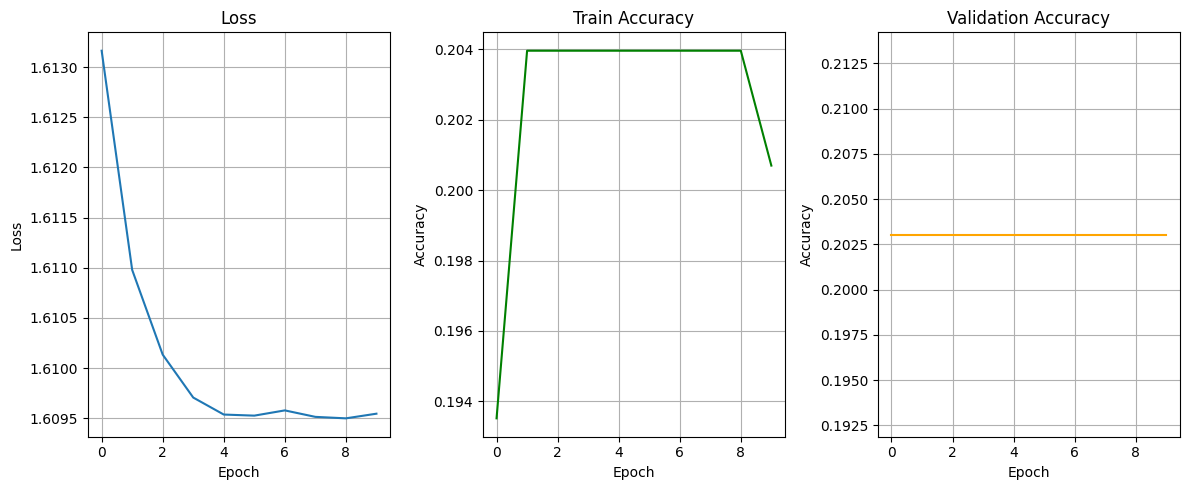

In [216]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

plt.tight_layout()
plt.show()

In [235]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: mean={param.data.mean():.4f}, grad={param.grad.mean() if param.grad is not None else 'N/A'}")


fc1.weight: mean=-0.0232, grad=0.0
fc1.bias: mean=-0.0243, grad=0.0
fc2.weight: mean=-0.0054, grad=0.0
fc2.bias: mean=-0.0162, grad=0.0
fc3.weight: mean=-0.0076, grad=0.0
fc3.bias: mean=-0.0158, grad=0.0
fc4.weight: mean=-0.0525, grad=0.0
fc4.bias: mean=-0.0218, grad=0.0
out.weight: mean=-0.0131, grad=0.0
out.bias: mean=-0.0014, grad=8.940697071579962e-09


In [225]:
for xb, yb in train_loader:
    if (yb == 0).all():
        break

print("Target class:", yb[0].item(), "shape:", xb.shape)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(xb)
    loss = los_funkcija(out, yb)
    loss.backward()
    optimizer.step()

    _, pred = torch.max(out, dim=1)
    acc = (pred == yb).float().mean().item()
    print(f"Epoch {epoch}: Loss={loss.item():.4f}, Acc={acc:.4f}, Pred={pred.tolist()}")

Target class: 0 shape: torch.Size([23, 11])
Epoch 0: Loss=1.6479, Acc=0.2174, Pred=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 1: Loss=1.6486, Acc=0.2174, Pred=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 2: Loss=1.6489, Acc=0.2174, Pred=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 3: Loss=1.6490, Acc=0.2174, Pred=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 4: Loss=1.6488, Acc=0.2174, Pred=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 5: Loss=1.6485, Acc=0.2174, Pred=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 6: Loss=1.6479, Acc=0.2174, Pred=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 7: Loss=1.6471, Acc=0.2174, Pred=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 8: Loss=1.6462, Acc=0.2174, Pred=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,